In [1]:
# !pip install transformers tokenizers -q

In [1]:
from modeling import *
from trainer import *
from dataloader import *

from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("Paired"))

rcParams['figure.figsize'] = 12,8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Датасет

In [2]:
df = pd.read_excel('test.xlsx')
df.head()

,q,a,tq,ta,label
0,"Здравствуйте, подскажите пожалуйста, я обучала...",Здравствуйте. По данному вопросу обратитесь по...,"[38209., 5750., 343., 64617., 38645., 56033., ...","[70433., 33013.]",7
1,"Здраствуйте, если ты уже зачислен на первый ку...",Здравствуйте. Вам необходимо сообщить об этом ...,"[45783., 33649., 733., 33980., 2993.]","[18016., 29619., 38602.]",2
2,Здравствуйте! В магистратуре можно ли поменять...,Здравствуйте. По данному вопросу обратитесь по...,"[5081., 42173., 15234., 14159.]","[70433., 33013.]",2
3,"Добрый день, а можно узнать стипендию на факул...",Здравствуйте. По данному вопросу вам необходим...,"[5081., 4045., 30799., 68380.]","[18016., 29619., 32373.]",15
4,"Здравствуйте, как получить справку для родител...",Здравствуйте. По данному вопросу вам необходим...,"[18348., 53039., 31590., 48341., 1046.]","[18016., 29619., 32373.]",6


In [3]:
sorted(df.label.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

[Text(0, 0, 'знакомство'),
 Text(0, 1, 'МИCиC'),
 Text(0, 2, 'поступление - перевод'),
 Text(0, 3, 'общежитие'),
 Text(0, 4, 'учебная деятельность'),
 Text(0, 5, 'внеучебная деятельность'),
 Text(0, 6, 'документы'),
 Text(0, 7, 'заказ услуг'),
 Text(0, 8, 'сайт'),
 Text(0, 9, 'Мoсква'),
 Text(0, 10, 'другие города'),
 Text(0, 11, 'я'),
 Text(0, 12, 'ИИ'),
 Text(0, 13, 'работа'),
 Text(0, 14, 'обязанности студента'),
 Text(0, 15, 'финансы')]

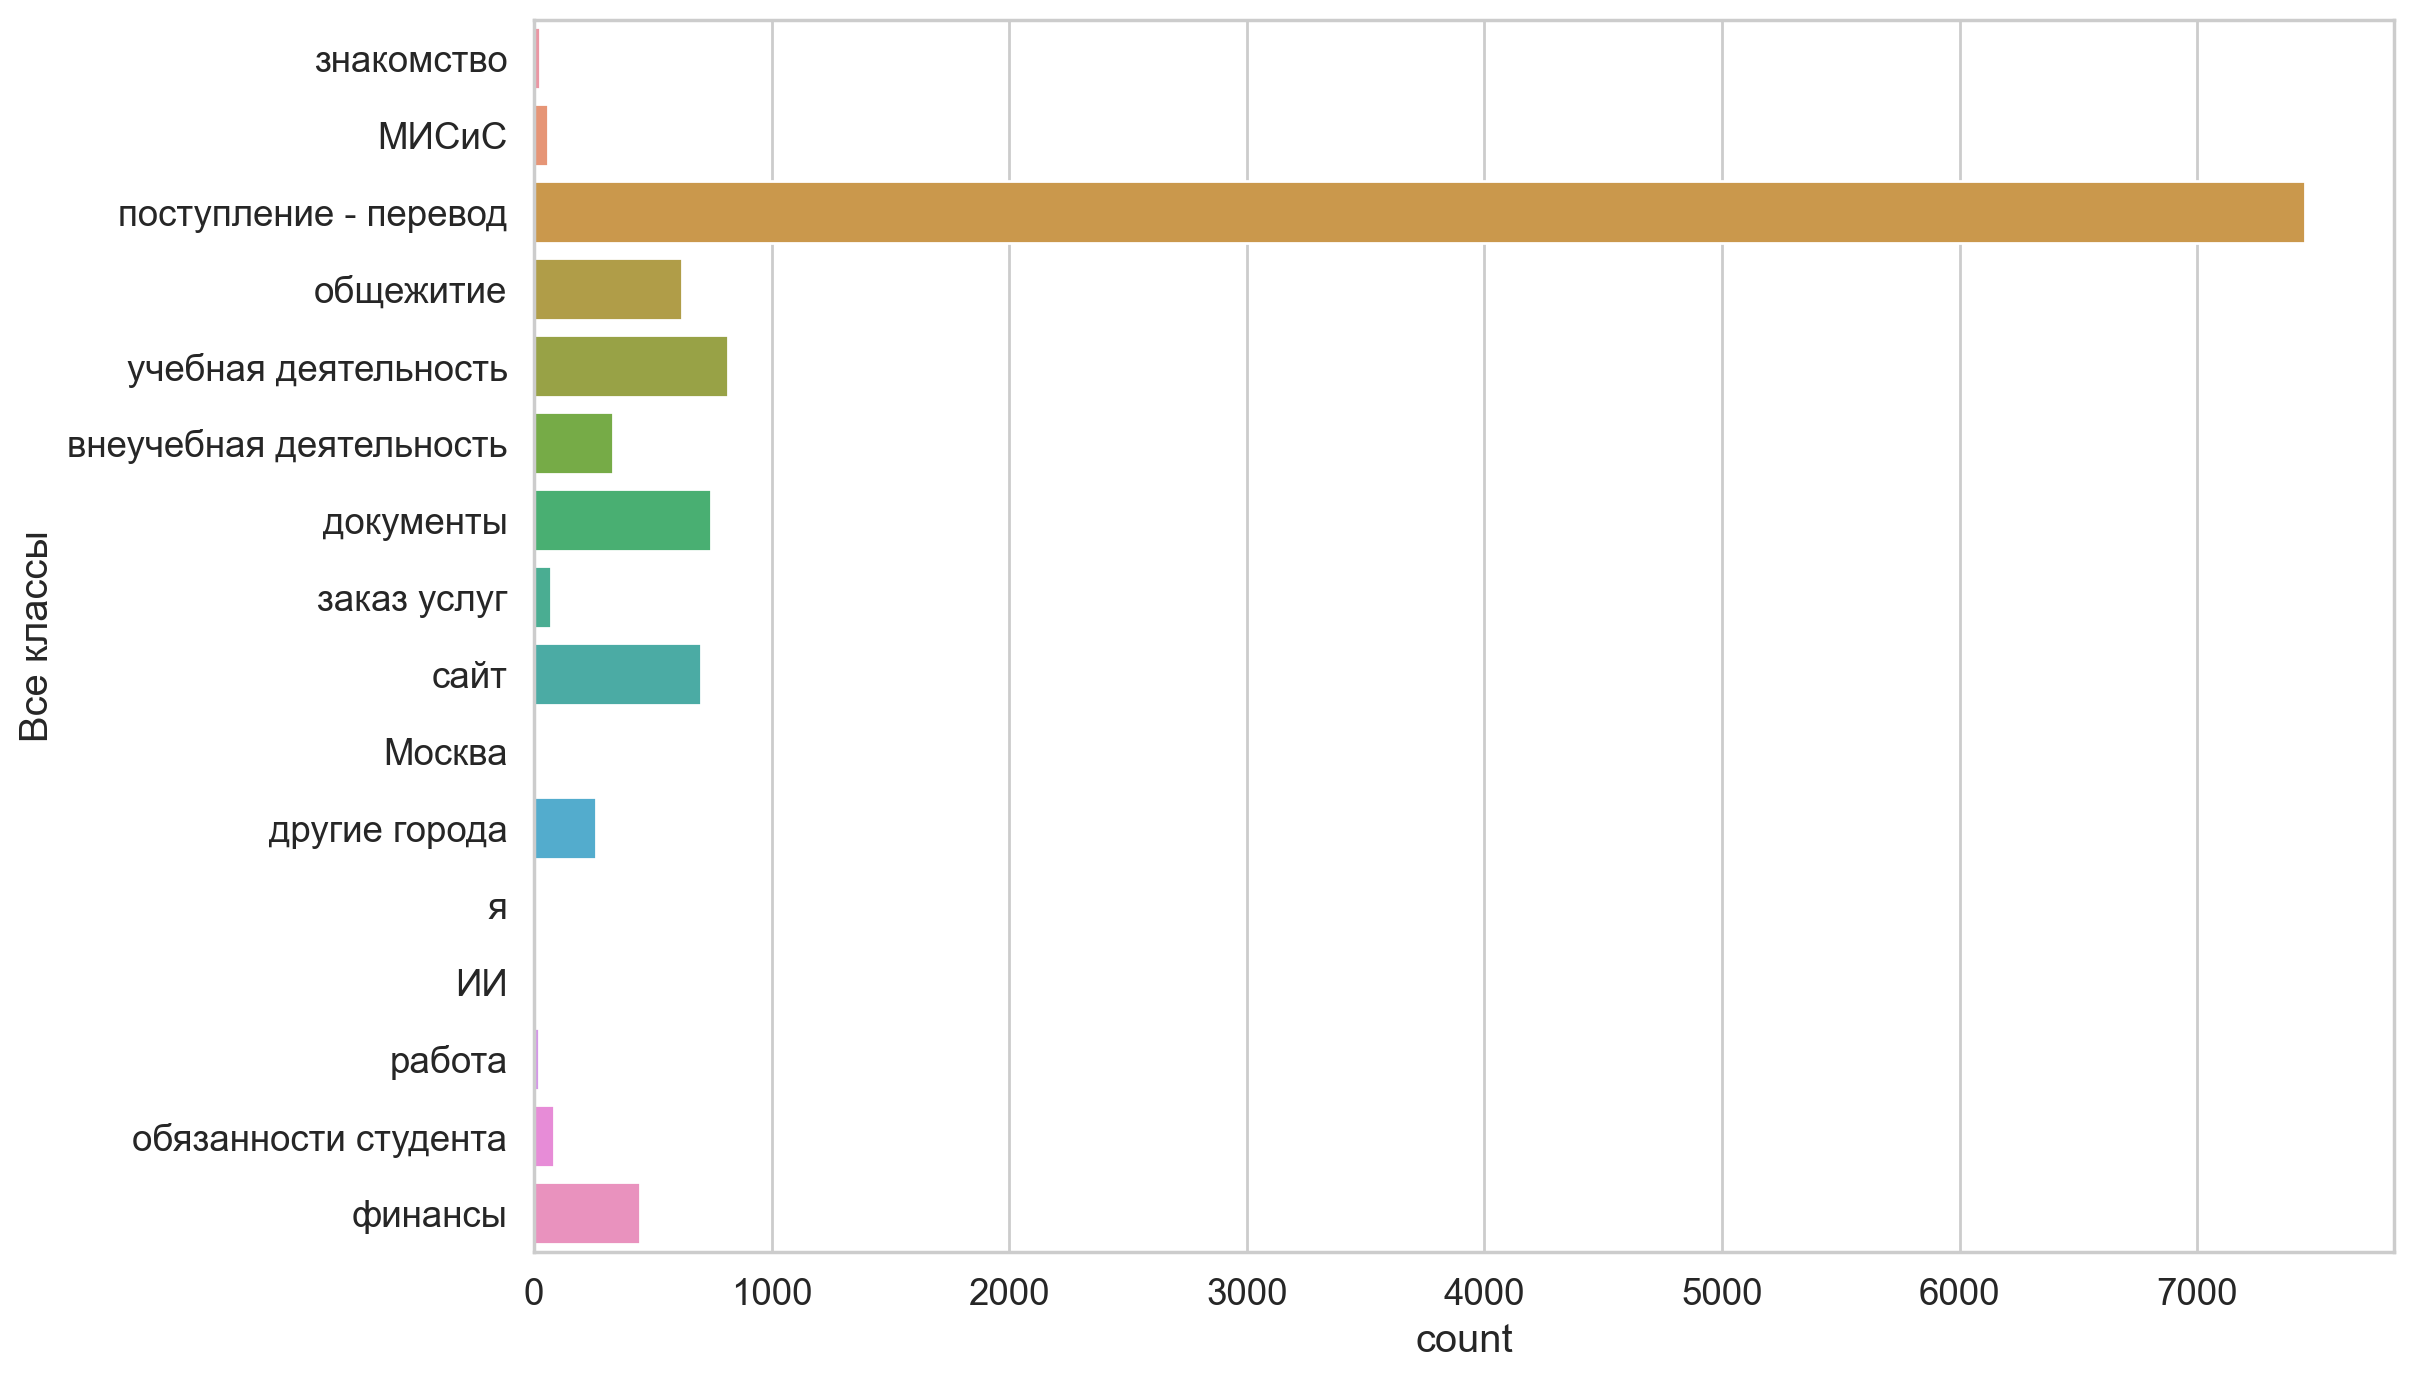

In [5]:
class_names = ['знакомство', 'МИCиC', 'поступление - перевод', 'общежитие', 'учебная деятельность', 'внеучебная деятельность', 'документы', 'заказ услуг', 'сайт', 'Мoсква','другие города', 'я', 'ИИ', 'работа', 'обязанности студента', 'финансы']

ax = sns.countplot(y = df.label)

plt.ylabel('Все классы')

ax.set_yticklabels(class_names)

# Токенизация и кодирование на образце текста

In [6]:
tokenizer = BertTokenizer.from_pretrained(pre_trained_model_ckpt)

In [8]:
sample_txt = 'Здравствуйте, подскажите пожалуйста, я обучалась в нгту, кампусная карта уже была, поступила в магистратуру, заполнила данные для кампусной карты, позже увидела, что не надо было заполнять, а можно просто разблокировать в бюро пропусков, мне теперь нужно новую кампусную карту забирать или можно просто разблокировать? То что я ввела данные для кампусной карты, ничего страшного?'

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=1000,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    padding=True,
    return_attention_mask=True,
    return_tensors='pt')  # Return PyTorch tensors)

print(f'Encoding keys: {encoding.keys()}')
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'])
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

 Sentence: Здравствуйте, подскажите пожалуйста, я обучалась в нгту, кампусная карта уже была, поступила в магистратуру, заполнила данные для кампусной карты, позже увидела, что не надо было заполнять, а можно просто разблокировать в бюро пропусков, мне теперь нужно новую кампусную карту забирать или можно просто разблокировать? То что я ввела данные для кампусной карты, ничего страшного?
   Tokens: ['Здравствуй', '##те', ',', 'подс', '##каж', '##ите', 'пожалуйста', ',', 'я', 'обучалась', 'в', 'нг', '##ту', ',', 'кампус', '##ная', 'карта', 'уже', 'была', ',', 'поступила', 'в', 'магистрат', '##уру', ',', 'заполн', '##ила', 'данные', 'для', 'кампус', '##ной', 'карты', ',', 'позже', 'увидела', ',', 'что', 'не', 'надо', 'было', 'заполня', '##ть', ',', 'а', 'можно', 'просто', 'разблок', '##ировать', 'в', 'бюро', 'пропуск', '##ов', ',', 'мне', 'теперь', 'нужно', 'новую', 'кампус', '##ную', 'карту', 'забирать', 'или', 'можно', 'просто', 'разблок', '##ировать', '?', 'То', 'что', 'я', 'ввела', '

### Количество токенов в вопросах

c:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Количество токенов')

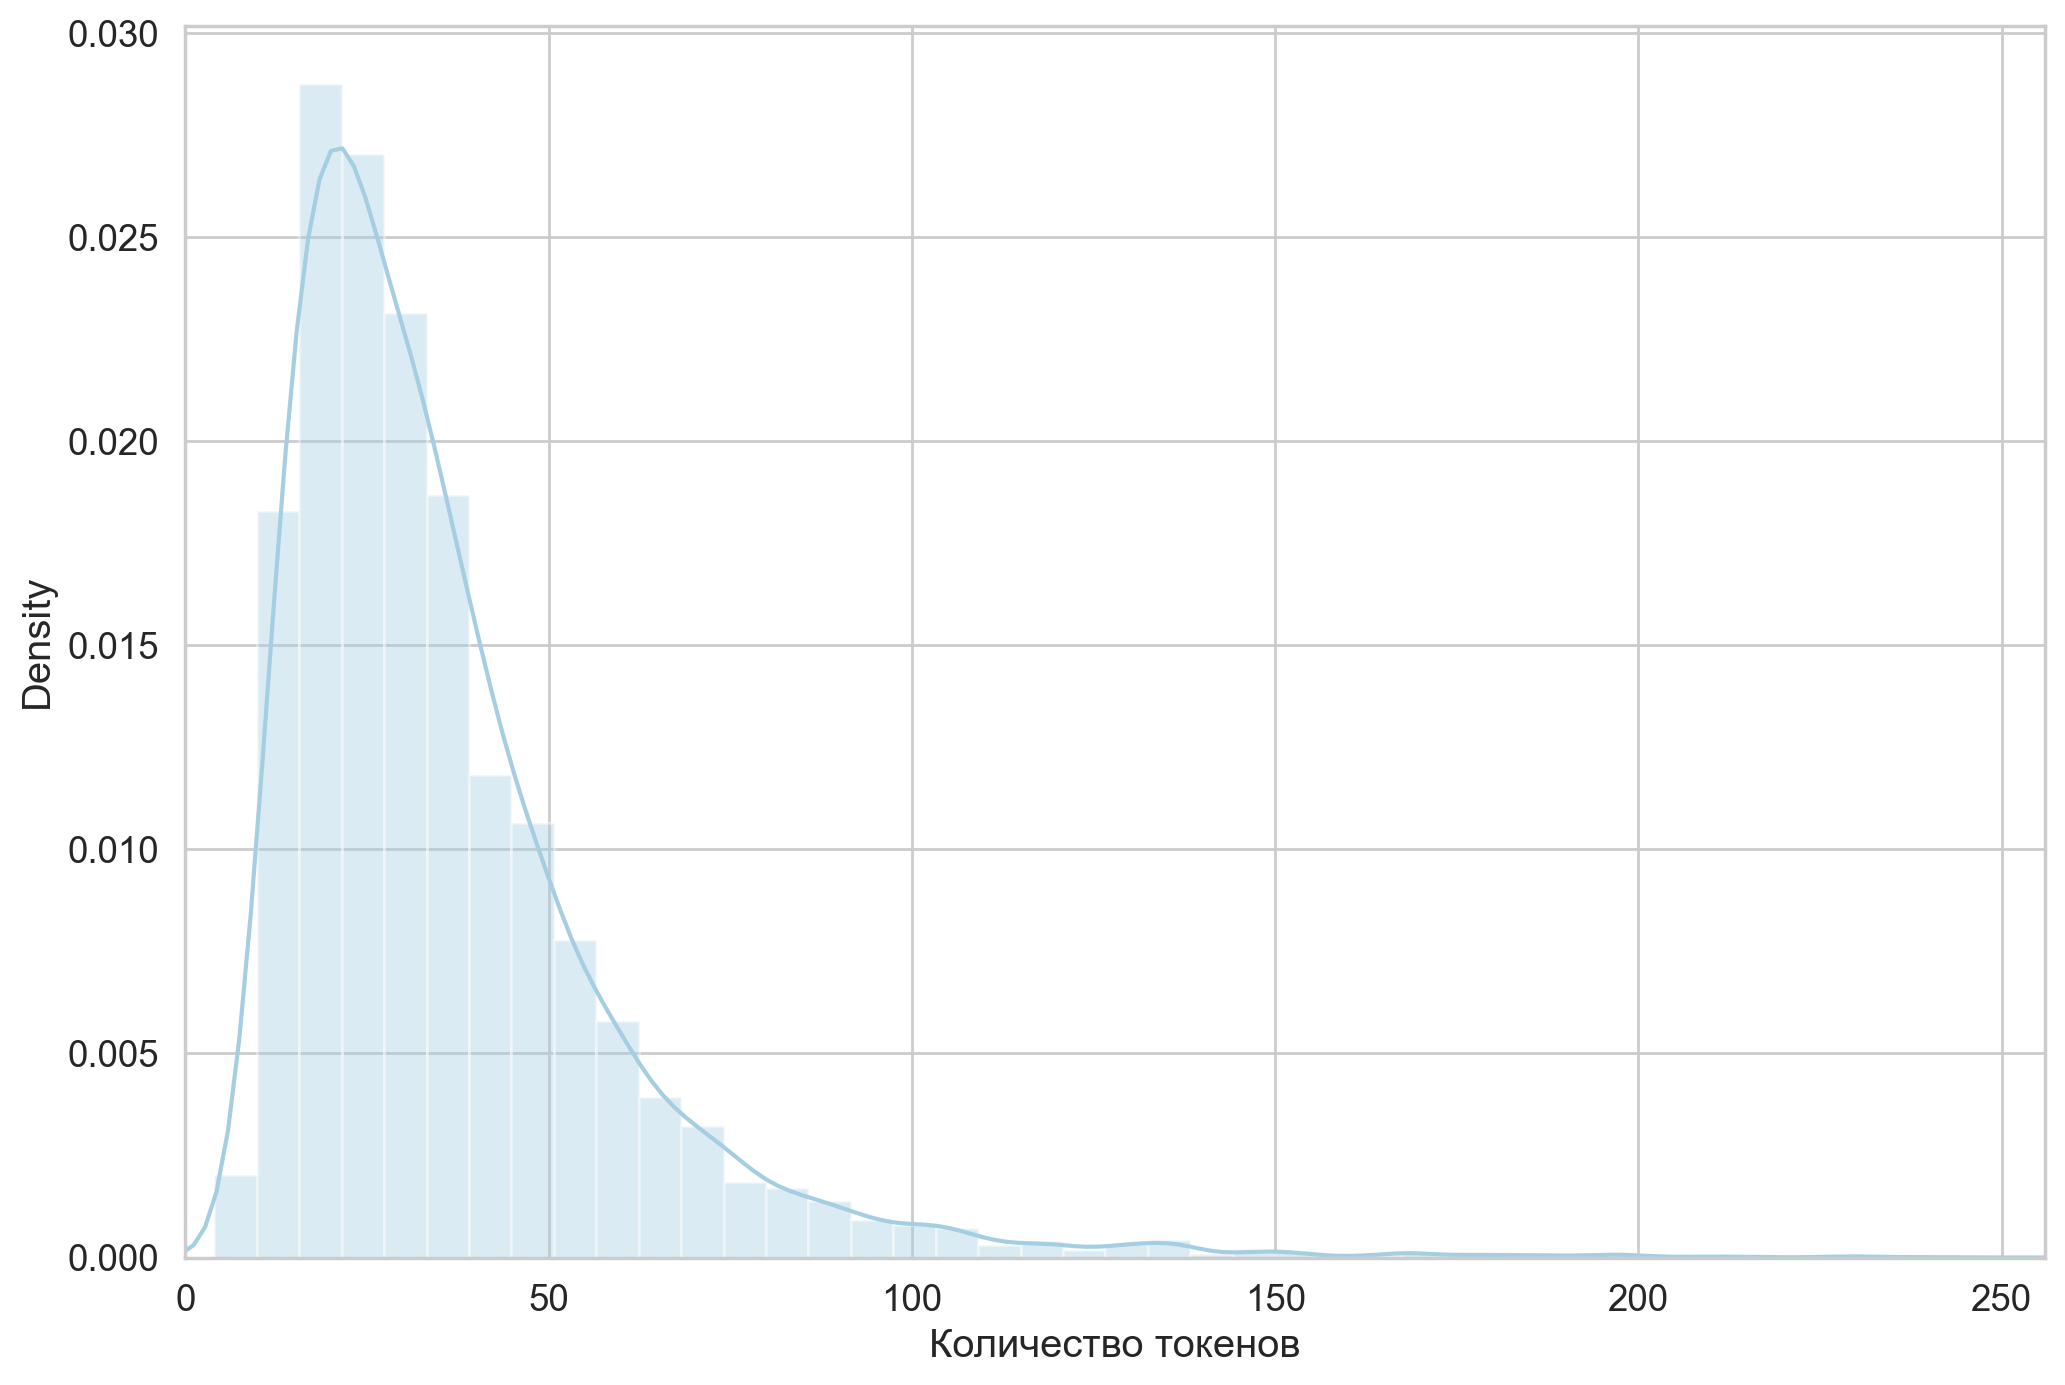

In [9]:
token_lens = []

for txt in df.q:
    tokens = tokenizer.encode(txt, truncation=True, max_length=512)
    token_lens.append(len(tokens))


sns.distplot(token_lens)

plt.xlim([0,256])

plt.xlabel('Количество токенов')

# Подготовка датасета

In [10]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(9318, 5) (1165, 5) (1165, 5)


In [11]:
train_data_loader = create_data_loader(df_train, tokenizer, batch_size = 8)
val_data_loader = create_data_loader(df_val, tokenizer, include_raw_text=False)
test_data_loader = create_data_loader(df_test, tokenizer, include_raw_text=False)

In [12]:
for d in val_data_loader:
    print(d.keys())
    
# dict_keys(['input_ids', 'attention_mask', 'targets', 'review_text'])

dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'attention_mask', 'targets'])
dict_keys(['input_ids', 'att

In [13]:
##Тестируем, чтобы убедиться, что даталоадер работает должным образом
data = next(iter(train_data_loader))

print(data.keys()) # dict_keys(['input_ids', 'attention_mask', 'targets'])

print(data['input_ids'].shape) # torch.Size([16, 512])

print(data['attention_mask'].shape) # torch.Size([16, 512])

print(data['targets'].shape) # torch.Size([16])

dict_keys(['input_ids', 'attention_mask', 'targets'])
torch.Size([8, 143])
torch.Size([8, 143])
torch.Size([8])


# Модель

In [14]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

# Just An evaluation run of the model
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids,attention_mask), dim = 1)


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.0607, 0.0659, 0.0719, 0.0708, 0.0562, 0.0713, 0.0619, 0.0623, 0.0736,
         0.0636, 0.0564, 0.0629, 0.0582, 0.0617, 0.0453, 0.0572],
        [0.0605, 0.0727, 0.0674, 0.0501, 0.0575, 0.0584, 0.0542, 0.0474, 0.0781,
         0.0766, 0.0583, 0.0644, 0.0745, 0.0598, 0.0573, 0.0628],
        [0.0725, 0.0645, 0.0700, 0.0601, 0.0646, 0.0658, 0.0548, 0.0624, 0.0663,
         0.0699, 0.0555, 0.0590, 0.0681, 0.0444, 0.0564, 0.0658],
        [0.0599, 0.0709, 0.0757, 0.0639, 0.0601, 0.0665, 0.0497, 0.0599, 0.0706,
         0.0647, 0.0503, 0.0623, 0.0672, 0.0677, 0.0504, 0.0603],
        [0.0543, 0.0734, 0.0810, 0.0638, 0.0527, 0.0712, 0.0634, 0.0617, 0.0743,
         0.0622, 0.0518, 0.0560, 0.0626, 0.0598, 0.0530, 0.0589],
        [0.0546, 0.0737, 0.0754, 0.0607, 0.0674, 0.0660, 0.0533, 0.0624, 0.0747,
         0.0736, 0.0511, 0.0564, 0.0535, 0.0697, 0.0520, 0.0555],
        [0.0575, 0.0683, 0.0840, 0.0557, 0.0579, 0.0683, 0.0580, 0.0661, 0.0720,
         0.0557, 0.0435, 0.0680, 0.06

# Тренируем

In [15]:
EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr= 1e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 16, 
    num_training_steps=total_steps)

# для мульти классификации
loss_fn = nn.CrossEntropyLoss().to(device)


## Тренировачный цикл

In [16]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  

Epoch 1/ 10
---------------


# Оценка модели на test_data_loader

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')

# y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

ValueError: Number of classes, 13, does not match size of target_names, 16. Try specifying the labels parameter

In [ ]:
review_text = "I could share photos seamlessly with this app"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')



Review text: I could share photos seamlessly with this app
Sentiment  : 5-Star


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
review_text = "I could share photos seamlessly with this app, but the UI could be better"
encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False, pad_to_max_length=True, return_attention_mask=True,
                                       truncation=True, return_tensors='pt')
input_ids = encoded_review['input_ids'].to(device)
attention_mask=encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_,prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I could share photos seamlessly with this app, but the UI could be better
Sentiment  : 3-Star
